## Portfolio optimization - Example

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0102939451022
            Iterations: 20
            Function evaluations: 141
            Gradient evaluations: 20


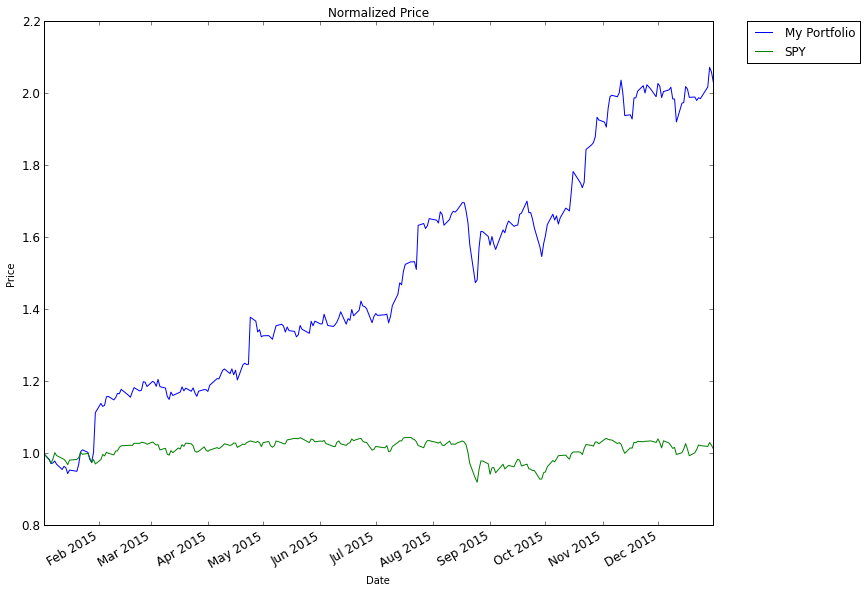

Start Date: 2015-01-01 00:00:00
End Date: 2016-01-01 00:00:00
Symbols: ['SPY', 'AMZN', 'FB', 'AXY', 'GLD']
Allocations: [  0.00000000e+00   8.00466296e-01   3.75384523e-17   1.99533704e-01
   5.01830697e-18]
Sharpe Ratio: 0.0102939451022
Volatility (stdev of daily returns): 0.0183066460907
Average Daily Return: 0.00299151306517
Cumulative Return: 1.03175903721


In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 


def symbol_to_path(symbol, base_dir="data"):
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df


def compute_daily_returns(df):
    # Compute + return daily return values
    daily_rets = df.copy()
    daily_rets[1:] = (df[1:] / df[:-1].values) - 1

    return daily_rets[1:]


def compute_portfolio_stats(prices, start_val, allocs = [0.1,0.2,0.3,0.4,0.2], rfr = 0.0, sf = 252.0):
    normed_prices = prices / prices.ix[0]  # normalized prices
    alloced = normed_prices * allocs  # allocating weights accordingly
    port_vals = alloced.sum(axis=1)  # porfolio value is sum of all allocations
    daily_returns = compute_daily_returns(port_vals)
    
    cr = (port_vals[-1] / port_vals[0]) - 1  # cumulative returns
    adr = daily_returns.mean()  # avg. daily returns
    sddr = daily_returns.std()  # volatility (std dev of daily returns)
    sr = (daily_returns - rfr).mean() / (np.sqrt(sf) * (daily_returns).std()) # sharpe ratio

    return cr, adr, sddr, sr, port_vals


def function(allocs, prices, start_val = 1000000, rfr = 0.0, sf = 252.0):
    cr, adr, sddr, sr, port_val = compute_portfolio_stats(prices, start_val, allocs, rfr, sf)
    
    return -sr


def optimize_portfolio(sd = dt.datetime(2015,1,1), ed = dt.datetime(2016,1,1), syms=['SPY','AMZN','FB','AXY','GLD'], gen_plot=False):

    # Read in adjusted closing prices for given symbols + date range
    dates = pd.date_range(sd, ed)
    prices_all = get_data(syms, dates)  # automatically adds SPY
    
    # Fill empty trade dates (for AXY)
    prices_all.fillna(method="ffill", inplace="True")
    prices_all.fillna(method="bfill", inplace="True")
    
    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later

    # find allocations for optimal portfolio
    # estimate = np.ones(len(syms)) * (1.0/len(syms))
    estimate = np.ones(len(syms)) * (1.0/len(syms))
    bounds = [(0,1.0) for i in range(len(syms))]
    allocs = minimize(function, estimate, args=(prices,), bounds=bounds, method='SLSQP', 
                            options={'disp':True}, 
                            constraints=({ 'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)})).x
    
    # print "allocs_optimizer..."
    # print allocs

    cr, adr, sddr, sr, port_val = compute_portfolio_stats(prices, start_val=1.0, allocs=allocs, rfr=0.0, sf=252.0)

    # Get daily portfolio value
    normed_prices = prices / prices.ix[0]  # normalized prices
    alloced = normed_prices * allocs  # allocating weights accordingly
    port_vals = alloced.sum(axis=1)  # porfolio value is sum of all allocations
    port_val = compute_daily_returns(port_vals)

    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        df_temp = pd.concat([port_vals, prices_SPY/prices_SPY[0]], keys=['My Portfolio', 'SPY'], axis=1)
        
        # plot_data(df_temp, ylabel="Normalized Price")
        ax = df_temp.plot(title="Normalized Price",fontsize=12,figsize=(12,10))
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        # plt.show()
        
        plt.show()
        pass

    return allocs, cr, adr, sddr, sr


def test_code():
    start_date = dt.datetime(2015,1,1)
    end_date = dt.datetime(2016,1,1)
    symbols = ['SPY','AMZN','FB','AXY','GLD']

    # Assess the portfolio
    allocations, cr, adr, sddr, sr = optimize_portfolio(sd = start_date, ed = end_date,syms = symbols, gen_plot = True)

    # Print statistics
    print "Start Date:", start_date
    print "End Date:", end_date
    print "Symbols:", symbols
    print "Allocations:", allocations
    print "Sharpe Ratio:", sr
    print "Volatility (stdev of daily returns):", sddr
    print "Average Daily Return:", adr
    print "Cumulative Return:", cr

    
if __name__ == "__main__":
    test_code()